In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sobol_seq
from scipy.stats import qmc

Problem 1

In [2]:
m_cluster = 100
gamma = -0.2
epsilon = 10**(-3)
delta = 0.01
k_cluster = 100
m = 500
r = 0.95
theta = np.pi/4
k_max = 250
dim = 2

def objective_function(x):
    f1 = np.exp(x[0]-x[1])-np.sin(x[0]+x[1])
    f2 = (x[0]*x[1])**2-np.cos(x[0]+x[1])
    return np.array([f1,f2])

boundaries = np.array([(-10,10) for _ in range (dim)])

Objective Function

In [3]:
def root_objective_function(x:np.ndarray):
    res = 0
    F_array = objective_function(x)
    for f in F_array:
        res += np.abs(f)
    return -1/(1+res)

In [4]:
"""GENERATE POINTS USING SOBOL SEQUENCE"""
def generate_points(dim: int, npoint: int, low=-10, high=10, sobol=True, seed=None):
    """
            Generates points within the specified bounds.

        Args:
            dim: Number of dimensions.
            npoint: Number of points to generate.
            low: Lower bound for each variable (scalar or list/numpy array).
            high: Upper bound for each variable (scalar or list/numpy array).
            sobol: Flag indicating whether to use Sobol sequence (True) or random sampling (False).

        Returns:
            A numpy array of size (npoint, dim) representing the generated points.
    """

    if type(low) != type(high):
        raise TypeError('The type of "low" and "high" should be the same.')

    # Handle boundaries
    if type(low) == int:
        boundaries = [(low, high) for _ in range(dim)]
    elif type(low) in (list, np.ndarray):
        if len(low) != len(high):
            raise TypeError('The length of "low" and "high" should be the same.')
        else:
            boundaries = [(low[i], high[i]) for i in range(len(low))]

    # Generate points based on the sobol flag
    if sobol:
        sampler = qmc.Sobol(d=dim,scramble=True,seed=seed)
        sample = sampler.random(n=npoint)
        scaled_points = qmc.scale(sample=sample,l_bounds=low,u_bounds=high)

    else:
        # Generate random points
        np.random.seed(seed)
        scaled_points = np.zeros((npoint, dim))
        for i in range(dim):
            min_val, max_val = boundaries[i]
            scaled_points[:, i] = np.random.uniform(min_val, max_val, npoint)

    return scaled_points

In [5]:
k=0
iter_points = {}
iter_points[k] = generate_points(dim,m_cluster,boundaries[:,0],boundaries[:,1])
fitness = np.asarray([root_objective_function(ind) for ind in iter_points[0]])
best_idx = np.argmin(fitness)
x_prime = iter_points[0][best_idx]

radius = (boundaries[:,1]-boundaries[:,0])/2
id_rad = np.argmin(radius)
radii = radius[id_rad]

cluster_center,cluster_radius = np.array([x_prime]),np.array([radii])
# cluster_center[0],cluster_radius[0] = x_prime,radius
print(cluster_center,cluster_radius)

[[-9.12130566e+00  4.04523686e-03]] [10.]


c:\Users\ACER\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [6]:
"""FUNCTION CLUSTER"""
def function_cluster(y):
    global cluster_center, cluster_radius
    dist_list = np.linalg.norm(cluster_center-y,axis=1)
    min_dist_id = np.argmin(dist_list)
    min_dist = dist_list[min_dist_id]
    xc = cluster_center[min_dist_id]
    xt = (xc + y)/2
    # print(xt,xc,y)
    Fxt = root_objective_function(xt)
    Fxc = root_objective_function(xc)
    Fy = root_objective_function(y)
    # print(Fxt,Fxc,Fy)
    if (Fxt > Fy) & (Fxt > Fxc):
        cluster_center = np.append(cluster_center,[y],axis=0)
        cluster_radius = np.append(cluster_radius, [np.linalg.norm(y-xt)],axis=0)
    elif (Fxt < Fy) & (Fxt < Fxc):
        cluster_center = np.append(cluster_center,[y],axis=0)
        cluster_radius = np.append(cluster_radius, [np.linalg.norm(y-xt)],axis=0)
        function_cluster(xt)
    elif Fy < Fxc:
        cluster_center[min_dist_id] = y
    
    cluster_radius[min_dist_id] =  np.linalg.norm(y-xt)
    # # update radii if the existing corresponding cluster radii is larger than tha candidate
    # if cluster_radius[min_dist_id] > np.linalg.norm(y-xt):
    #     cluster_radius[min_dist_id] =  np.linalg.norm(y-xt)
    
    # return cluster_center,cluster_radius


In [7]:
# import importlib.util
# spec = importlib.util.spec_from_file_location("spo", r"D:\OneDrive - Institut Teknologi Bandung\[AKADEMIK]\Semester 7-8\TA\Thesis\Spiral Optimization\new\Spiropt.py")
# spo = importlib.util.module_from_spec(spec)
# spec.loader.exec_module(spo)

import Spiropt as spo
import re
import importlib
importlib.reload(spo)

<module 'Spiropt' from 'd:\\OneDrive - Institut Teknologi Bandung\\[AKADEMIK]\\Semester 7-8\\TA\\Thesis\\Thesis - Python\\Spiral Optimization\\new\\Spiropt.py'>

In [8]:
seed = np.random.randint(0,100)
print(f"seed={seed}")

while k<k_cluster:
    potential_cluster_center = []
    F = root_objective_function(iter_points[k].T)
    for i in range (m_cluster):
        # If F(x_i)<gamma and x_i is not the center of existing cluster, x_i may have a possibility to become a cluster center
        if len(iter_points[k].T) == 1:
            fungam = F[0][i]
        else:
            fungam = F[i]
        exist_in_cluster_center = any(np.linalg.norm(iter_points[k][i] - ctr) < epsilon for ctr in cluster_center)
        if (fungam < gamma) & (exist_in_cluster_center==False):
            potential_cluster_center.append(iter_points[k][i])
        # print(f'potential_cluster_center:{potential_cluster_center}')
    # Apply function cluster
    for i in range (len(potential_cluster_center)):
        function_cluster(potential_cluster_center[i])

    Rn = spo.generate_Rn(dim,theta)
    Sn = r*Rn
    iter_points[k+1] = spo.update_point(set_of_points=iter_points[k],
                                    objective_function=root_objective_function,
                                    Sn=Sn)

    k+=1
print(f"len(cluster_center)={len(cluster_center)}\ncluster_center={cluster_center}")

seed=93
len(cluster_center)=40
cluster_center=[[-9.12130566e+00  4.04523686e-03]
 [-9.09360170e-01  1.11988276e+00]
 [ 7.83915073e-02  7.97352139e+00]
 [-6.34072721e-02  2.65859602e+00]
 [-6.96766969e+00  2.05300836e-01]
 [-1.38949790e-01  3.10275206e-01]
 [-7.88416818e-01  9.41474249e-01]
 [-1.78870980e+00  1.16233099e-01]
 [-2.94401656e+00 -9.61775601e-02]
 [-3.21388336e+00  3.26465908e-02]
 [-2.38942870e+00  1.02320264e-01]
 [-2.92518907e+00  4.21875961e-02]
 [-9.43028865e-01  1.05592560e+00]
 [-4.79614945e+00  5.11550006e-02]
 [-4.22233236e+00  6.70533152e-02]
 [-4.58158154e+00  1.21560703e-03]
 [-1.63922738e+00  1.65565499e-01]
 [-2.26745869e+00 -6.50929807e-02]
 [-4.83109278e+00  1.34013248e-01]
 [-3.19924345e+00  6.11250954e-02]
 [-1.14617440e+00  8.54592554e-01]
 [-9.16488568e-01  1.05543110e+00]
 [-8.77050259e-01  1.08993478e+00]
 [-9.48260143e-01  1.05514493e+00]
 [-9.52285488e-01  1.04895370e+00]
 [-1.10023042e+00  8.88232760e-01]
 [-9.81220272e-01  1.00965133e+00]
 [-9.7625

Cluster Visualization

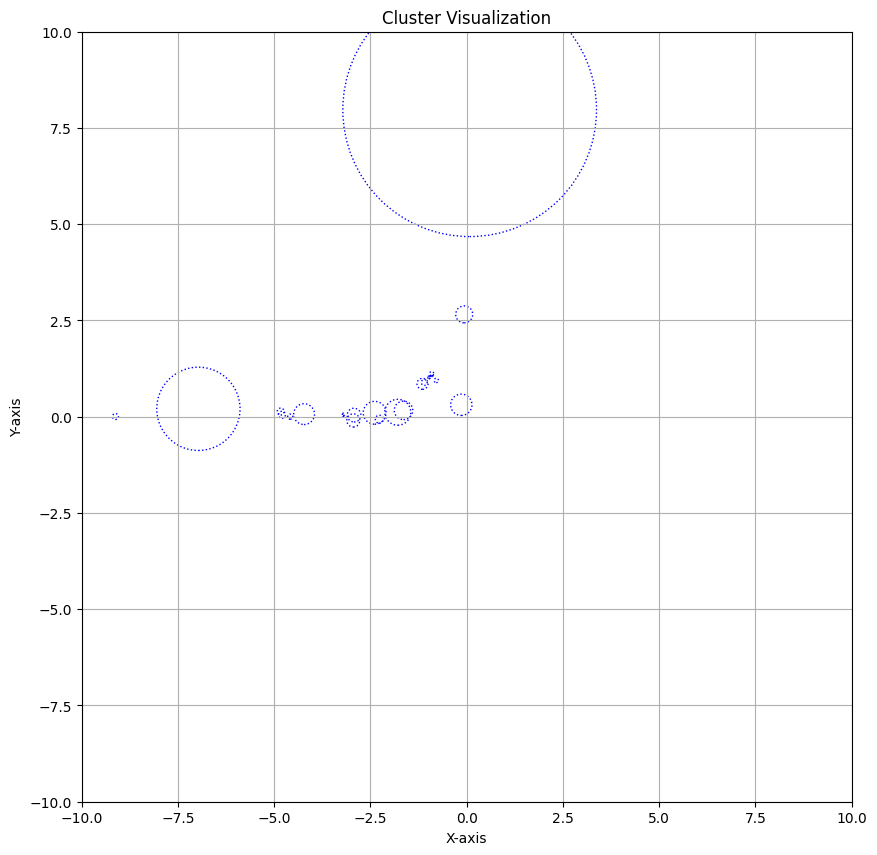

In [9]:
if dim != 2:
    print(f"Dimension {dim} can be visualized using cluster_visualization2D.")
"""Visualization"""
fig, ax = plt.subplots(figsize=(10,10))
for center,radius in zip(cluster_center,cluster_radius):
    circle = plt.Circle(center, radius, fill=False, linestyle='dotted', edgecolor='b')
    ax.add_artist(circle)

# Set axis limits
ax.set_xlim(boundaries[0])
ax.set_ylim(boundaries[1])
# ax.autoscale_view()

# # Add labels (optional)
# for i, center in cluster_center.items():
#     ax.text(center[0], center[1], f'Cluster {i+1}', ha='center', va='bottom')

# Add a title and labels (optional)
ax.set_title('Cluster Visualization')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Show the plot
plt.gca().set_aspect('equal', adjustable='box')  # Make the aspect ratio equal
plt.grid(True)
plt.show()

In [10]:
answ = np.array([[-6.437160, 0.155348],
                 [-0.932122, 1.067870],
                 [-0.155283, 6.439840],
                 [0.163333, 6.122430],
                 [0.667121, 0.690103],
                 [-6.117110, -0.163476]])

possible_cluster_id = []
for i in range (len(cluster_center)):
    for j in range (len(answ)):
        ddist = np.linalg.norm(cluster_center[i]-answ[j])
        if ddist <= cluster_radius[i]:
            possible_cluster_id.append([i,j])
            print(f'cluster_center[{i}] x answ[{j}]')


cluster_center[2] x answ[2]
cluster_center[2] x answ[3]
cluster_center[4] x answ[0]
cluster_center[4] x answ[5]


# Spiral Optimization Evaluation

In [11]:
archive = []
for i in range (len(cluster_center)):
    # subbound = np.array([cluster_center[i]-np.abs(cluster_radius[i]),cluster_center[i]+np.abs(cluster_radius[i])])
    subbound = np.array([[c-cluster_radius[i],c+cluster_radius[i]] for c in cluster_center[i]])
    root, root_score = spo.spiral_opt(objective_function=root_objective_function,
                                      boundaries=subbound,
                                      n_point=m,
                                      theta=theta,
                                      radius=r,
                                      max_iter=k_max,
                                      max_error=-1+epsilon,
                                      seed=None)
    archive.append(root)
    print(f'\n====== Cluster {i} ======\n')
    print(f'Roots = {archive}')
archive


====== Cluster 0 ======

Roots = [array([-9.19651720e+00, -4.16257881e-03])]

====== Cluster 1 ======

Roots = [array([-9.19651720e+00, -4.16257881e-03]), array([-0.93093689,  1.06905929])]

====== Cluster 2 ======

Roots = [array([-9.19651720e+00, -4.16257881e-03]), array([-0.93093689,  1.06905929]), array([0.16337336, 6.12094693])]

====== Cluster 3 ======

Roots = [array([-9.19651720e+00, -4.16257881e-03]), array([-0.93093689,  1.06905929]), array([0.16337336, 6.12094693]), array([0.04949832, 2.87122216])]

====== Cluster 4 ======

Roots = [array([-9.19651720e+00, -4.16257881e-03]), array([-0.93093689,  1.06905929]), array([0.16337336, 6.12094693]), array([0.04949832, 2.87122216]), array([-6.13238635, -0.16306252])]

====== Cluster 5 ======

Roots = [array([-9.19651720e+00, -4.16257881e-03]), array([-0.93093689,  1.06905929]), array([0.16337336, 6.12094693]), array([0.04949832, 2.87122216]), array([-6.13238635, -0.16306252]), array([0.13454195, 0.56937082])]

====== Cluster 6 =====

[array([-9.19651720e+00, -4.16257881e-03]),
 array([-0.93093689,  1.06905929]),
 array([0.16337336, 6.12094693]),
 array([0.04949832, 2.87122216]),
 array([-6.13238635, -0.16306252]),
 array([0.13454195, 0.56937082]),
 array([-0.83943407,  0.99614666]),
 array([-1.53243371,  0.44477289]),
 array([-3.11096831, -0.05295197]),
 array([-3.18514945e+00,  2.26667578e-03]),
 array([-2.68167253, -0.02607395]),
 array([-3.09974779, -0.04575255]),
 array([-0.9434376 ,  1.05656069]),
 array([-4.87511702,  0.06430141]),
 array([-4.48592174, -0.01838416]),
 array([-4.64828414, -0.02271055]),
 array([-1.57226937,  0.39280117]),
 array([-2.1652253 ,  0.02483978]),
 array([-4.90654019,  0.07133546]),
 array([-3.21107381,  0.03036354]),
 array([-1.01319311,  0.98680688]),
 array([-0.92230917,  1.06053359]),
 array([-0.89017488,  1.10075248]),
 array([-0.94576   ,  1.05423905]),
 array([-0.94630808,  1.05369068]),
 array([-1.03961828,  0.96038131]),
 array([-0.96712861,  1.03287119]),
 array([-0.9467802

In [12]:
if dim == 1:
    list_criteria = [element for sublist in archive for element in sublist] #convert from 2D array into 1D array
else:
    list_criteria = archive
eligible_roots = np.array([x for x in list_criteria if (root_objective_function(x))<-1+epsilon])
eligible_roots

array([], dtype=float64)

In [13]:
id_duplicated_roots = []
for i in range(len(eligible_roots)):
    for j in range (i+1,len(eligible_roots)):
        if np.linalg.norm(eligible_roots[i]-eligible_roots[j])<delta:
            id_duplicated_roots.append([i,j])
id_duplicated_roots = np.unique(id_duplicated_roots,axis=0)
deselected_id_duplicated_roots = []
for i in range (len(id_duplicated_roots)):
    root_a = root_objective_function(eligible_roots[id_duplicated_roots[i][0]])
    root_b = root_objective_function(eligible_roots[id_duplicated_roots[i][1]])
    if root_a<=root_b:
        id_duplicated_root = id_duplicated_roots[i][1]
    else:
        id_duplicated_root = id_duplicated_roots[i][0]
    deselected_id_duplicated_roots.append(id_duplicated_root)

if deselected_id_duplicated_roots:
    unique_roots = np.ones(len(eligible_roots),dtype=bool)
    unique_roots[deselected_id_duplicated_roots] = False
    final_root = eligible_roots[unique_roots]
else:
    final_root = eligible_roots

final_root

array([], dtype=float64)

In [65]:
import pandas as pd
import re
import matplotlib.pyplot as plt

sean = pd.read_csv(r"D:\OneDrive - Institut Teknologi Bandung\[AKADEMIK]\Semester 7-8\TA\Thesis\Thesis - Matlab\Spiral Optimization\cluster_sean.csv", header=None)
bunovri = pd.read_csv(r"D:\OneDrive - Institut Teknologi Bandung\[AKADEMIK]\Semester 7-8\TA\Thesis\Thesis - Matlab\SpiralTest\cluster_bunovri.csv",header=None)
sean.shape, bunovri.shape

((48, 3), (19, 3))

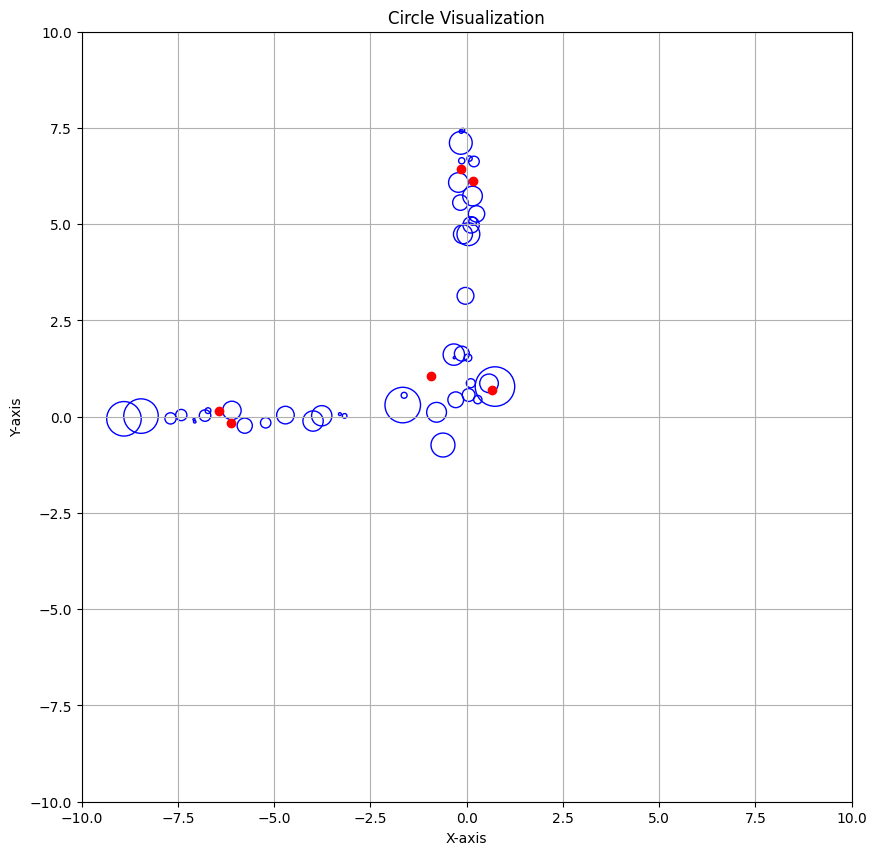

In [66]:
def plot_circle(ax, center, radius):
    # Extract x and y coordinates from the center array
    x_center, y_center = center

    # Plot the circle
    circle = plt.Circle((x_center, y_center), radius, color='blue', fill=False)

    # Add the circle to the plot
    ax.add_artist(circle)

    # Set equal aspect ratio to ensure the circle is displayed as a circle
    ax.set_aspect('equal', adjustable='box')

    # Set axis limits
    ax.set_xlim(x_center - radius - 1, x_center + radius + 1)
    ax.set_ylim(y_center - radius - 1, y_center + radius + 1)

    # Set labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Circle Visualization')
    ax.grid(True)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10,10))

# Define center points and radii for multiple circles
centers = sean.iloc[:,:2].values
radii = sean.iloc[:,2].values

# Plot each circle
for center, radius in zip(centers, radii):
    plot_circle(ax, center, radius)

ax.scatter(answ[:, 0], answ[:, 1], color='red', label='Points')

ax.set_xlim(boundaries[0])
ax.set_ylim(boundaries[1])
# Show the plot
plt.show()


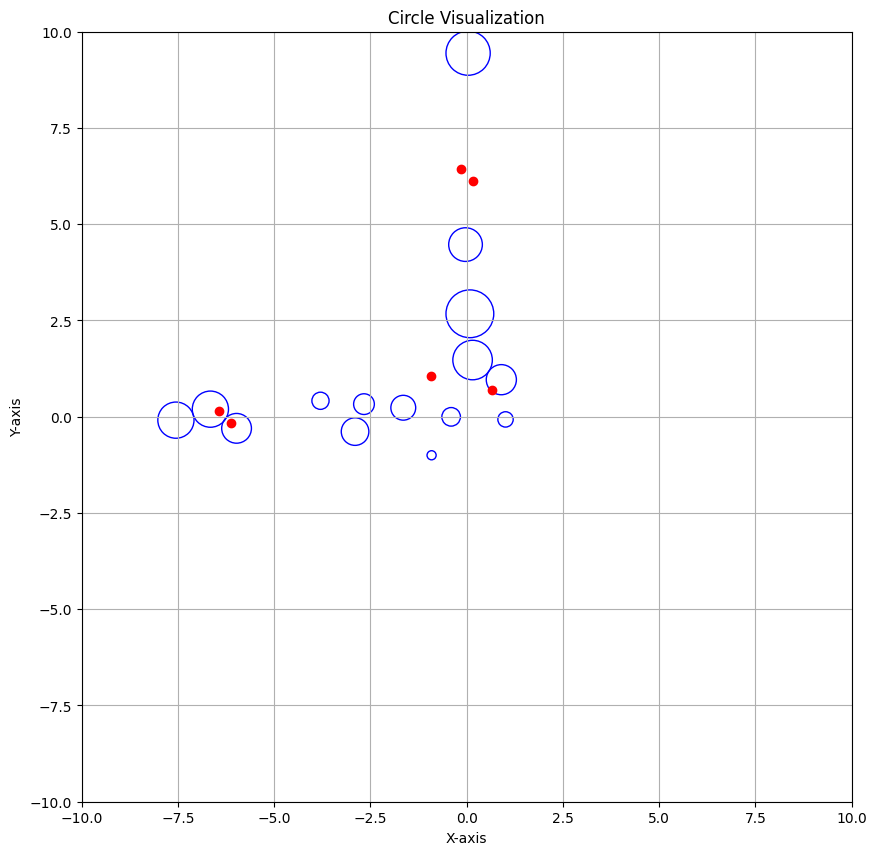

In [67]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10,10))

# Define center points and radii for multiple circles
centers = bunovri.iloc[:,:2].values
radii = bunovri.iloc[:,2].values

# Plot each circle
for center, radius in zip(centers, radii):
    plot_circle(ax, center, radius)

ax.scatter(answ[:, 0], answ[:, 1], color='red', label='Points')

ax.set_xlim(boundaries[0])
ax.set_ylim(boundaries[1])
# Show the plot
plt.show()